Environment:   Assume your domain is the x-y plane.   To start, you have the obstacle:  circle with radius = 4 and center = (11,11).

/home/jonathan/python_envs/base/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


<IPython.core.display.Javascript object>


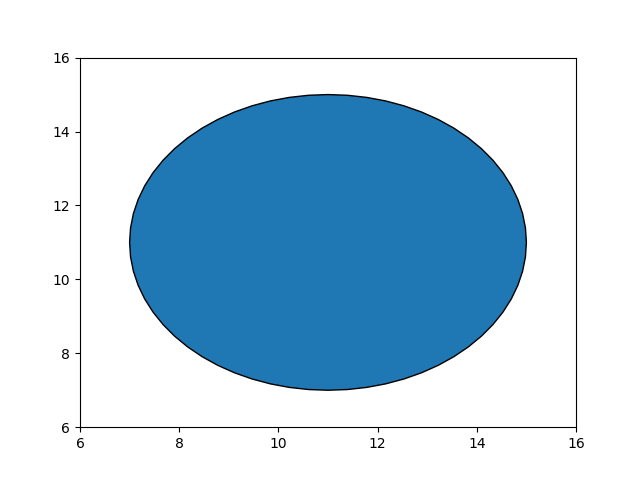

(6.0, 16.0)

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import shapely.geometry as geom
import descartes as dc

rect = geom.Polygon([ (8,6),(8,8),(6,8),(6,6)]) 
circle = geom.Point(11,11).buffer(4)

circle_patch = dc.PolygonPatch(circle)

fig,ax = plt.subplots()
ax.add_patch(circle_patch)
ax.set_xlim(6,16)
ax.set_ylim(6,16)

Using one of the planners, find (approximately) the shortest path from (9,15) to (15,9).   Plot the domain, the obstacle and the path. 

In [2]:
class Node():
    def __init__(self, xy, hfunc):
        self.neighbors = {}
        self.g = np.Inf
        self.xy = np.array(xy)
        self.hfunc = hfunc

    def __lt__(self, other):
        lt = False
        f1 = self.g+self.hfunc(self.xy)
        f2 = other.g+self.hfunc(self.xy)
        if np.abs(f1-f2) < 0.001:
            #print("almost equal")
            lt = self.g > other.g
        else:
            lt = f1 < f2
            
        #lt = f1 < f2
        return lt

    def __eq__(self, other):
        return all(self.xy == other.xy)
    
    def __call__(self):
        return self.hfunc(np.array([self.x, self.y]))
        try:
            return self.f
        except:
            self.f = self.g+self.hfunc(np.array([self.x, self.y]))
            return self.f


class Graph():
    def __init__(self, dist_func):
        self.nodes = {}
        self.dist_func = dist_func
        
    def __iadd__(self, t):
        n1 = t[0]
        n2 = t[1]
        weight = t[2]
        self.connect(n1, n2, weight)
        return graph
        
    def connect(self, n1, n2, weight):
        try:
            self.nodes[n1].neighbors[n2] = weight
        except KeyError:
            self.nodes[n1] = Node(n1, self.hfunc)
            self.nodes[n1].neighbors[n2] = weight
        try:
            self.nodes[n2].neighbors[n1] = weight
        except KeyError:
            self.nodes[n2] = Node(n2,self.hfunc)
            self.nodes[n2].neighbors[n1] = weight

    def draw(self, ax):
        for pt in self.nodes:
            node = self.nodes[pt]
            for neighbor in node.neighbors:
                ax.plot([pt[0],neighbor[0]],[pt[1], neighbor[1]],'k')
                
    def hfunc(self, node):
        return self.dist_func(node, self.goal)
        

def h_l2_dist(node, goal):
    return np.linalg.norm(node-goal)

In [3]:
import heapq

def a_star(graph, start, goal, max_iter = np.Inf):
    start_node = graph.nodes[start[0], start[1]]
    start_node.g = 0

    goal_node = graph.nodes[goal[0], goal[1]]
    graph.goal = goal

    start_node.goal = goal
    Q = [start_node]
    heapq.heapify(Q)
    searched = []
    curr_node = start_node
    count = 0
    while len(Q) > 0 and curr_node != goal_node and count < max_iter:
        curr_node = heapq.heappop(Q)
        count += 1

        searched.append(curr_node.xy)
        for neighbor in curr_node.neighbors:
            weight = curr_node.neighbors[neighbor]
            try:
                other_node = graph.nodes[neighbor]
                if curr_node.g + weight < other_node.g:
                    other_node.g = curr_node.g + weight
                    other_node.prev = curr_node
                    if other_node not in Q:
                        other_node.goal = goal
                        heapq.heappush(Q, other_node)
            except:
                pass
    if len(Q) == 0:
        print("No solution found")
        return graph, np.array([[start_node.x, start_node.y]]), np.array(searched), 0
    path = [curr_node.xy]
    path_length = 0
    while curr_node != start_node:
        path.insert(0, curr_node.prev.xy)
        path_length += np.linalg.norm(curr_node.xy-curr_node.prev.xy)
        curr_node = curr_node.prev

    return graph, np.array(path), np.array(searched), path_length

<IPython.core.display.Javascript object>


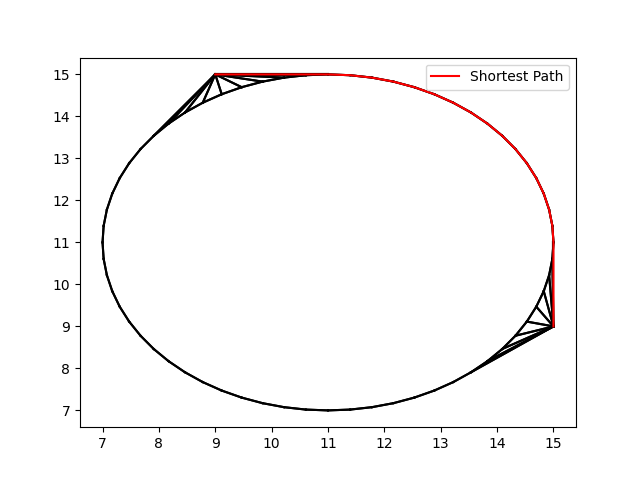

In [4]:
start_pt = (9,15)
goal_pt = (15,9)

graph = Graph(h_l2_dist)

obstacles = [circle]

vertices = [start_pt, goal_pt]
for obs in obstacles:
    vertices += [*obs.boundary.coords]

for p1 in vertices:
    for p2 in vertices:
        l = geom.LineString([p1, p2])

        if not any((l.crosses(obs) or l.within(obs)) for obs in obstacles):
            graph += (p1, p2, np.linalg.norm( np.array(p1)-np.array(p2)))

new_graph, path, searched, path_length = a_star(graph, start_pt, goal_pt)

fig, ax = plt.subplots()
graph.draw(ax)
ax.plot(path[:,0], path[:,1],'r',label='Shortest Path')
plt.legend()

Assume that the path is the end-effector of a two link manipulator with arm lengths a1 = 10 and a2 = 10.    The base of the arm is (0,0).   Feed 5 to 15 of the path points into the inverse kinematics.  Plot the arms, path, and obstacle on the domain.   You may want to only plot 5.   Pick representative plots to show what the arm is doing?   Are there any issues?

<IPython.core.display.Javascript object>


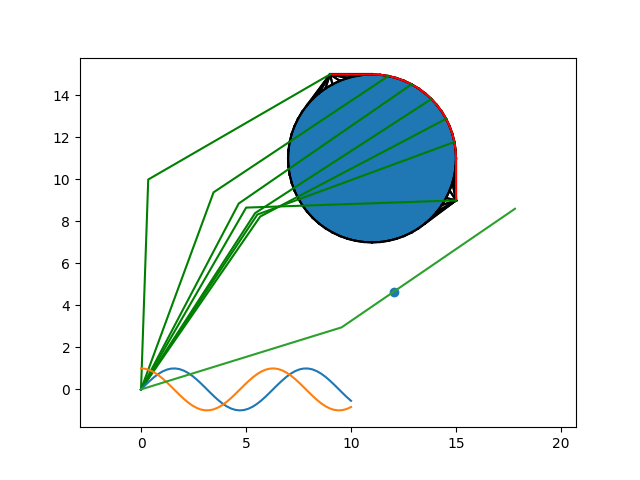

/home/jonathan/python_envs/base/lib/python3.9/site-packages/descartes/patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([


(-0.75, 15.75, -0.7500000000020574, 15.750000000043203)

In [5]:
import scipy.optimize as opt

a1 = 10
a2 = 10
base = (0,0)

def fk(thetas):
    t1 = thetas[0]
    t2 = thetas[1]
    x1 = a1*np.cos(t1)
    y1 = a1*np.sin(t1)
    
    x2 = x1 + a2*np.cos(t1+t2)
    y2 = y1 + a2*np.sin(t1+t2)
    
    return np.array([(0,0),(x1,y1),(x2,y2)])

def ik(xy, t_guess=np.array((0,0))):
    def diff(thetas):
        base, j1, j2 = fk([thetas[0], thetas[1]])
        return j2 - xy
    res = opt.fsolve(diff, t_guess)
    return res


base, j1, j2 = fk([0.2,-0.1])

#print(ik(j2))
    
thetas = np.array([0,0])
bases = []
j1s = []
j2s = []

fig, ax = plt.subplots()
patches = []
for obs in obstacles:
    patch = dc.PolygonPatch(obs)
    patches.append(patch)
    ax.add_patch(patch)
ax.set_xlim(0,16)
ax.set_ylim(0,16)
graph.draw(ax)
ax.plot(path[:,0],path[:,1],'r')
for i in range(0,len(path),3):
    pt = path[i]
    thetas = ik(pt,thetas)
    #base,j1,j2 = fk(thetas)
    res = fk(thetas)
    bases.append(base)
    j1s.append(j1)
    j2s.append(j2)
    ax.plot(res[:,0],res[:,1],'g')

ax.axis('equal')

    

Oh No!!! The manipulator is going through the obstacle. The horror!

Write some code to determine what the obstacle looks like in configuration space.  Don't just focus on the end-effector; you also need to consider intermediate link - obstacle collisions.    Plot the obstacle in config space.    Plot the configuration space path on the previous plot.  What happens if you add quadrant 3 as an obstacle?

In order to simplify the solution to start with, I'm only going to consider intersections with the second link. For this problem, that is totally adequate because the obstacle will never touch the first link. We can parameterize the intersection point on the second arm by creating an auxiliary variable, $s$ that will vary between 0 and 1. When $s=0$ the point will be at the joint between arms 1 and 2. When $s=1$, the point will be at the end effector. With this approach, we can define any point within the workspace, $q$, with the following equations:

$$ p_1 = \left< a_1 cos(\theta_1), a_1 sin(\theta_1) \right> $$
$$ p_2 = p_1 + \left< a_2 cos(\theta_1 + \theta_2), a_2 sin(\theta_1 + \theta_2)\right> $$
$$ q(\theta_1, \theta_2, s) = s \cdot p_2 + (1-s)\cdot p_1 $$

For a given point, $q$, we can now define all the configurations that intersect with that point as the set of $\theta_1$, $\theta_2$, $0<=s<=1$ that solves the above equation.

Once we have found one solution to this equation, we can discover others by perturbing $\theta_1$, $\theta_2$, and $s$ such that the total derivative of q with respect to time is zero. The Jacobian represents the partial derivatives of this equation with respect to each of the independent variables, thus the nullspace of the Jacobian represents the direction in which we should travel in order to hold $q$ constant while varying the independent variables. Put another way, we want to solve the following differential equation:
$$ \frac{\partial q}{\partial \theta_1} \frac{d\theta_1}{d t} + \frac{\partial q}{\partial \theta_2} \frac{d\theta_2}{d t} + \frac{\partial q}{\partial s} \frac{ds}{d t} = 0$$

to find $\theta_1(t)$, $\theta_2(t)$, and $s(t)$

Thankfully this is easily done numerically using the `scipy.integrate.solve_ivp()` function which will numerically solve an initial value problem. We simply have to define a function which takes in the state, $[\theta_1, \theta_2, s]$ and returns $[\dot \theta_1, \dot \theta_2, \dot s]$.

In order to avoid computing a bunch of partial derivatives by hand, in the following section I create an autodifferentiation class compatible with numpy. Once that has been done, I define the `fk_arm()` function to do the forward_kinematics according to the definition of $q$ above. The `fk_arm_jac()` function then uses the autodifferentiation class to compute the Jacobian of $q$. Finally, the `null_deriv()` function computes the nullspace of the Jacobian, correcting for sign flips, and allowing either forward or backward traversal via the `direction` argument.

Once all that has been defined, we can pass `null_deriv()` to the solve_ivp function to traverse the level set. We also define the `reached_p1()` and `reached_p2()` functions to enable solve_ivp to terminate when it has traversed all the way to the end of the arm.

In [6]:
import numpy as np

class D:
    
    def __init__(self, v, d=0):
        self.v = v
        self.d = d
        
    def __add__(self, other):
        try:
            a = other.d
        except AttributeError:
            other = D(other)
        newv = self.v + other.v
        newd = self.d + other.d
        
        return D(newv, newd)
    def __radd__(self, other):
        
        return self.__add__(other) 
    
    def __mul__(self, other):
        try:
            a = other.d
        except AttributeError:
            other = D(other)
        newv = self.v * other.v
        newd = self.v*other.d + self.d*other.v
        
        return D(newv, newd)
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def __sub__(self, other):
        try:
            a = other.d
        except AttributeError:
            other = D(other)
        newv = self.v - other.v
        newd = self.d - other.d
        
        return D(newv, newd)
    
    def __rsub__(self, other):
        try:
            a = other.d
        except AttributeError:
            other = D(other)
        newv = other.v - self.v
        newd = other.d - self.d
        
        return D(newv, newd)
    
    def __pow__(self, other):
        try:
            a = other.d
        except TypeError:
            other = D(other)
        newv = self.v**other.v
        newd = np.exp(other.v*np.log(self.v)) * (other.d * np.log(self.v) + other.v/self.v*self.d)
        
        return D(newv, newd)
    
    def __str__(self):
        return "({},{})".format(self.v, self.d)
    
    def __repr__(self):
        return self.__str__()
    
    def sin(self):
        newv = np.sin(self.v)
        newd = np.cos(self.v)*self.d
        
        return D(newv,newd)
    
    def cos(self):
        newv = np.cos(self.v)
        newd = -np.sin(self.v)*self.d
        return D(newv, newd)
    
x = np.array([D(i,1) for i in np.linspace(0,10)])

y = x**D(2,0)
y = np.sin(x)

plt.plot([i.v for i in x],[i.v for i in y])
plt.plot([i.v for i in x], [i.d for i in y])



/tmp/ipykernel_24139/1885364281.py:60: RuntimeWarning: divide by zero encountered in log
  newd = np.exp(other.v*np.log(self.v)) * (other.d * np.log(self.v) + other.v/self.v*self.d)
/tmp/ipykernel_24139/1885364281.py:60: RuntimeWarning: invalid value encountered in double_scalars
  newd = np.exp(other.v*np.log(self.v)) * (other.d * np.log(self.v) + other.v/self.v*self.d)
/tmp/ipykernel_24139/1885364281.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  newd = np.exp(other.v*np.log(self.v)) * (other.d * np.log(self.v) + other.v/self.v*self.d)


In [7]:
from scipy.integrate import solve_ivp
from scipy.linalg import null_space
import matplotlib.animation as animation

def fk_arm(data):
    t1 = data[0]
    t2 = data[1]
    s = data[2]
    #s = -0.5*np.cos(data[2])+0.5
    
    p1 = np.array([a1*np.cos(t1), a1*np.sin(t1)])
    p2 = p1 + np.array([a2*np.cos(t1+t2), a2*np.sin(t1+t2)])
    
    return p1*(1-s) + p2*s

def fk_arm_jac(data):
    J = []
    for i in range(len(data)):
        newdata = []
        for j in range(len(data)):
            temp = D(data[j])
            if i == j:
                temp.d = 1
            else:
                temp.d = 0
            newdata.append(temp)
        dpdi = fk_arm(newdata)
        J.append([dp.d for dp in dpdi])
    return np.array(J).T

def null_deriv(t, data, direction):
    J = fk_arm_jac(data)
    ns = null_space(J)[:,0]
    ns *= np.sign(ns[0])
    if direction == 'f':
        return ns
    else:
        return -ns

data = [0.3, 0.3, 0.3]
p = fk_arm(data)
joints = fk(data)

#print(fk_arm_jac(data))
#print(null_deriv(0, data,'f'))

plt.plot(joints[:,0], joints[:,1])
plt.scatter(p[0], p[1])

def reached_p1(t,data, direction):
    return data[2]
reached_p1.terminal = True

def reached_p2(t,data, direction):
    return data[2] - 1
reached_p2.terminal = True

t_f = 7
data0 = np.array([*ik(p),0.9999])
res = solve_ivp(null_deriv, (0,t_f), data0, args=("b"), t_eval=np.arange(0,t_f,0.02), events=(reached_p1, reached_p2))

In [8]:
print(res)

  message: 'A termination event occurred.'
     nfev: 38
     njev: 0
      nlu: 0
      sol: None
   status: 1
  success: True
        t: array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
       0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
       0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
       0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
       0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
       1.1 , 1.12, 1.14, 1.16, 1.18, 1.2 , 1.22, 1.24, 1.26, 1.28, 1.3 ,
       1.32, 1.34, 1.36, 1.38, 1.4 , 1.42, 1.44, 1.46, 1.48, 1.5 , 1.52,
       1.54, 1.56, 1.58, 1.6 , 1.62, 1.64, 1.66, 1.68, 1.7 , 1.72, 1.74,
       1.76, 1.78, 1.8 , 1.82, 1.84, 1.86, 1.88, 1.9 , 1.92, 1.94, 1.96,
       1.98, 2.  , 2.02, 2.04, 2.06, 2.08, 2.1 , 2.12, 2.14, 2.16, 2.18,
       2.2 , 2.22, 2.24, 2.26, 2.28, 2.3 , 2.32, 2.34, 2.36, 2.38, 2.4 ,
       2.42, 2.44, 2.46, 2.48, 2.5 , 2.52, 2.54, 2.56, 2.5

<IPython.core.display.Javascript object>


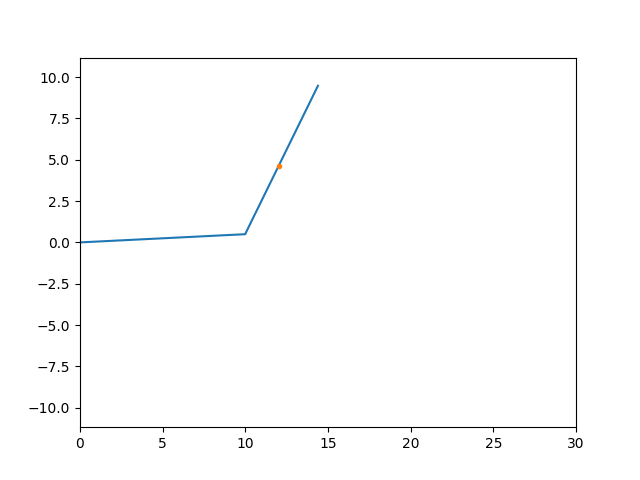

In [10]:
fig, ax = plt.subplots()

joints = fk(res.y.T[0])
l1, = ax.plot(joints[:,0],joints[:,1])
p1, = ax.plot(p[0],p[1],'.')

ax.axis('equal')
ax.set_ylim(-20,20)
ax.set_xlim(0,30)


def anim_func(i):
    print(i)
    data = res.y.T[i]
    joints = fk(data)
    p = fk_arm(data)
    l1.set_data(joints[:,0], joints[:,1])
    p1.set_data(p[0],p[1])

    return l1, p1

func = animation.FuncAnimation(fig, anim_func, frames=len(res.y.T),interval=20)
plt.show()

In [ ]:
def draw_manipulator(data, ax):
    joints = fk(data)
    p = fk_arm(data)
    l1 = ax.plot(joints[:,0],joints[:,1])
    p1 = ax.plot(p[0],p[1],'.')

fig, ax = plt.subplots()
#for data in res_f.y.T:
#    draw_manipulator(data, ax)
for i in range(0,len(res_b.y.T), 10):
    data = res_b.y.T[i]
    draw_manipulator(data, ax)
    

In [ ]:
fig, ax = plt.subplots()

line, = 

Find the points in config space that correspond to (9,15) and (15,9).   Using the obstacle you just computed.  Find a minimal path between the two computed points.  

Following the path you computed in #4, what is the path of the end-effector in the workspace.   Create a second plot that shows some sample arm configurations while moving along the path. 